# Proyecto 1 - Etapa 2



In [ ]:
%pip install fastapi uvicorn nest_asyncio

In [11]:
%pip install --quiet --upgrade openai

Note: you may need to restart the kernel to use updated packages.


In [2]:
# ==============================================================
#  PROYECTO 1 – ETAPA 2 (SECCIÓN 1)
#  Baseline (v1) → Aumentación ODS1 → Reentrenamiento (v2) → Comparación
# ==============================================================

# ========== 1) IMPORTS Y UTILIDADES ==========
import os
import json
import pandas as pd
import numpy as np
from joblib import dump, load
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, classification_report)
import matplotlib.pyplot as plt

# tqdm opcional
try:
    from tqdm import tqdm
    tqdm.pandas()
    USE_TQDM = True
except Exception:
    USE_TQDM = False

# ========== 2) LIMPIEZA Y LEMATIZACIÓN ==========
import spacy
try:
    nlp = spacy.load("es_core_news_sm")
except Exception as e:
    raise RuntimeError(
        "Falta el modelo de spaCy para español. Instala con:\n"
        "  python -m spacy download es_core_news_sm"
    ) from e

def clean_text(text):
    text = str(text).lower()
    text = text.replace('\n',' ').replace('\r',' ')
    text = ''.join(ch for ch in text if ch.isalnum() or ch.isspace())
    text = ' '.join(text.split())
    return text

def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([tok.lemma_ for tok in doc if not tok.is_stop and not tok.is_punct])

def apply_series(func, series):
    if USE_TQDM:
        return series.progress_apply(func)
    return series.apply(func)

100%|██████████| 2424/2424 [00:37<00:00, 64.08it/s]


=== v1 en HOLD-OUT original (Etapa 1) ===
Accuracy: 0.961
F1-macro: 0.956

=== Reporte de clasificación — v1 (baseline en hold-out original) ===
              precision    recall  f1-score   support

           1       0.97      0.90      0.93       101
           3       0.95      0.97      0.96       179
           4       0.97      0.99      0.98       205

    accuracy                           0.96       485
   macro avg       0.96      0.95      0.96       485
weighted avg       0.96      0.96      0.96       485



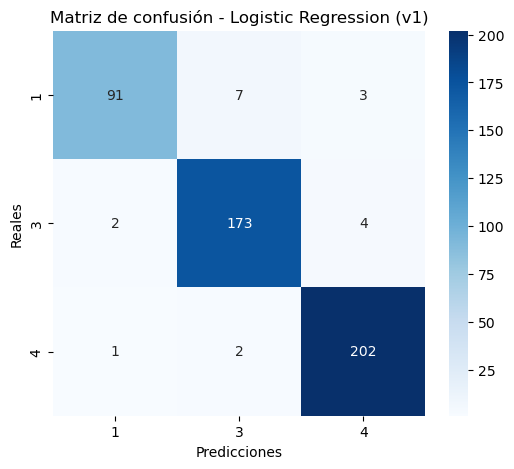

Guardados v1: model_LogisticRegression.joblib, tfidf_vectorizer.joblib



In [3]:
# ========== 3) DATOS ORIGINALES (ETAPA 1) Y v1 ==========
# Cambia el nombre si tu archivo es otro
import seaborn as sns
from sklearn.metrics import confusion_matrix

df_orig = pd.read_excel("data/Datos_proyecto.xlsx")
assert {"textos","labels"} <= set(df_orig.columns), f"Columnas esperadas no encontradas: {df_orig.columns}"

# Preparación idéntica a la Etapa 1
df_orig["texto_limpio"] = apply_series(clean_text, df_orig["textos"].astype(str))
df_orig["texto_lema"]   = apply_series(lemmatize_text, df_orig["texto_limpio"])

# Split reproducible (HOLD-OUT FIJO para comparación v1 vs v2)
X_train, X_test, y_train, y_test = train_test_split(
    df_orig["texto_lema"], df_orig["labels"],
    test_size=0.2, random_state=42, stratify=df_orig["labels"]
)

# Vectorizador y modelo v1 (misma configuración de la Etapa 1)
vectorizer_v1 = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9, sublinear_tf=True, norm="l2")
X_train_v1 = vectorizer_v1.fit_transform(X_train)
X_test_v1  = vectorizer_v1.transform(X_test)

logreg_v1 = LogisticRegression(max_iter=2000, solver="lbfgs")
logreg_v1.fit(X_train_v1, y_train)

# Métricas rápidas en el hold-out original (v1)
yhat_v1_hold = logreg_v1.predict(X_test_v1)
print("=== v1 en HOLD-OUT original (Etapa 1) ===")
print("Accuracy:", round(accuracy_score(y_test, yhat_v1_hold), 3))
print("F1-macro:", round(f1_score(y_test, yhat_v1_hold, average='macro'), 3))

# Reporte detallado de clasificación (por clase)
print("\n=== Reporte de clasificación — v1 (baseline en hold-out original) ===")
print(classification_report(y_test, yhat_v1_hold, zero_division=0))

# Matriz de confusión
cm = confusion_matrix(y_test, yhat_v1_hold, labels=logreg_v1.classes_)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,          # muestra los números
            fmt="d",             # formato enteros
            cmap="Blues",        # paleta de colores
            xticklabels=logreg_v1.classes_,  # nombres de clases eje X
            yticklabels=logreg_v1.classes_)  # nombres de clases eje Y
plt.xlabel("Predicciones")
plt.ylabel("Reales")
plt.title("Matriz de confusión - Logistic Regression (v1)")
plt.show()

# Guardar artefactos v1
dump(logreg_v1, "artifacts/model_LogisticRegression.joblib")
dump(vectorizer_v1, "artifacts/tfidf_vectorizer.joblib")
print("Guardados v1: model_LogisticRegression.joblib, tfidf_vectorizer.joblib\n")


In [5]:
# ========== FUNCIÓN AUXILIAR: obtener predicciones + probabilidad ==========
import numpy as np
import pandas as pd

def add_predictions_with_scores(df_texts, text_col, model, vectorizer, prefix="v1"):
    """
    Genera predicciones y probabilidades asociadas (score) para cada texto.
    Devuelve un DataFrame con columnas:
        pred_<prefix>: etiqueta predicha
        score_<prefix>: probabilidad asociada a esa etiqueta (top-1)
    """
    Xmat = vectorizer.transform(df_texts[text_col].astype(str))
    yhat = model.predict(Xmat)
    proba = model.predict_proba(Xmat)
    classes = model.classes_

    # índice de columna correspondiente a cada clase predicha
    col_index = {c: i for i, c in enumerate(classes)}
    idx = np.array([col_index[y] for y in yhat])
    score = proba[np.arange(len(yhat)), idx]

    out = df_texts.copy()
    out[f"pred_{prefix}"] = yhat
    out[f"score_{prefix}"] = score

    return out, classes


Nuevo dataset: filas=99 | columna texto='textos'


100%|██████████| 99/99 [00:01<00:00, 69.23it/s]


Predicciones v1 + score guardadas en: outputs/predicciones_v1_en_nuevo_set_con_score.csv
Clases del modelo v1: [1, 3, 4]

=== Reporte de clasificación — v1 (baseline en nuevo set) ===
              precision    recall  f1-score   support

           1       1.00      0.62      0.76        21
           3       0.85      1.00      0.92        35
           4       0.91      0.95      0.93        43

    accuracy                           0.90        99
   macro avg       0.92      0.86      0.87        99
weighted avg       0.91      0.90      0.89        99



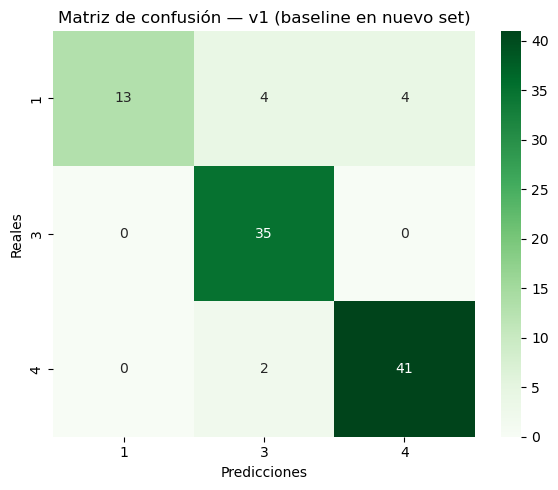

Baseline (v1) en nuevo set listo:
baseline_etapa2_macro.csv
baseline_etapa2_por_clase.csv
predicciones_v1_en_nuevo_set.csv
matriz_confusion_v1_nuevo_set.png



In [6]:
# ========== 4) NUEVO SET (ETAPA 2) → BASELINE CON v1 ==========
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Cambia el nombre si tu archivo es otro
df_new = pd.read_excel("data/Datos_Etapa 2.xlsx")

# Detecta columna de texto
TEXT_COL = "Textos_espanol" if "Textos_espanol" in df_new.columns else ("textos" if "textos" in df_new.columns else None)
assert TEXT_COL is not None, f"No encuentro columna de texto. Columnas: {list(df_new.columns)}"
assert "labels" in df_new.columns, f"Falta columna 'labels' en df_new."

print(f"Nuevo dataset: filas={len(df_new)} | columna texto='{TEXT_COL}'")

# Limpieza y lematización (idéntico a Etapa 1)
df_new["texto_limpio"] = apply_series(clean_text, df_new[TEXT_COL].astype(str))
df_new["texto_lema"]   = apply_series(lemmatize_text, df_new["texto_limpio"])

# Baseline v1 en el nuevo set
X_new = vectorizer_v1.transform(df_new["texto_lema"])
y_new = df_new["labels"]
yhat_new = logreg_v1.predict(X_new)

# --- guardar predicciones con score (v1) ---
preds_v1_df, classes_v1 = add_predictions_with_scores(df_new, "texto_lema", logreg_v1, vectorizer_v1, prefix="v1")
preds_v1_df.to_csv("outputs/predicciones_v1_en_nuevo_set_con_score.csv", index=False)
print("Predicciones v1 + score guardadas en: outputs/predicciones_v1_en_nuevo_set_con_score.csv")
print("Clases del modelo v1:", list(classes_v1))


# Reporte y métricas
rep_new_v1 = classification_report(y_new, yhat_new, output_dict=True, zero_division=0)
pd.DataFrame(rep_new_v1).to_csv("outputs/baseline_etapa2_por_clase.csv")

pd.DataFrame([{
    "accuracy": accuracy_score(y_new, yhat_new),
    "f1_macro": f1_score(y_new, yhat_new, average="macro")
}]).to_csv("outputs/baseline_etapa2_macro.csv", index=False)

df_new.assign(pred_v1=yhat_new).to_csv("predicciones_v1_en_nuevo_set.csv", index=False)

# === Reporte detallado ===
print("\n=== Reporte de clasificación — v1 (baseline en nuevo set) ===")
print(classification_report(y_new, yhat_new, zero_division=0))

# === Matriz de confusión ===
cm_new = confusion_matrix(y_new, yhat_new, labels=logreg_v1.classes_)

plt.figure(figsize=(6,5))
sns.heatmap(cm_new,
            annot=True,          # muestra los números
            fmt="d",             # formato enteros
            cmap="Greens",       # paleta de colores
            xticklabels=logreg_v1.classes_,
            yticklabels=logreg_v1.classes_)
plt.xlabel("Predicciones")
plt.ylabel("Reales")
plt.title("Matriz de confusión — v1 (baseline en nuevo set)")
plt.tight_layout()
plt.savefig("figures/matriz_confusion_v1_nuevo_set.png", dpi=150)
plt.show()

print("Baseline (v1) en nuevo set listo:")
print("baseline_etapa2_macro.csv")
print("baseline_etapa2_por_clase.csv")
print("predicciones_v1_en_nuevo_set.csv")
print("matriz_confusion_v1_nuevo_set.png\n")


In [7]:
# === 5.A) Verificar API Key (por variable de entorno) + instalar SDK y crear cliente ===
import os

# 1) Verifica que la llave esté cargada en el entorno (Opción A que configuraste)
key = os.environ.get("OPENAI_API_KEY", "")
assert key.startswith("sk-") and len(key) > 20, "No se encontró OPENAI_API_KEY. Revisa tu configuración de entorno."

from openai import OpenAI
client = OpenAI(api_key=key)

print("OPENAI_API_KEY cargada desde entorno y cliente creado.")


✅ OPENAI_API_KEY cargada desde entorno y cliente creado.


In [8]:
# 5.B) Utilidad: solicitar a OpenAI un array JSON de strings (con reintentos y parsing robusto)
import json, re, time

SYSTEM_PROMPT = "Eres un generador de datos sintéticos que escribe español de Colombia, siguiendo instrucciones y formatos estrictamente."

def ask_openai_json(user_prompt, model="gpt-4o-mini", temperature=0.7, max_retries=2, sleep_s=2):
    """
    Envía un prompt y devuelve una lista (array JSON) de strings no vacíos.
    Si hay texto extra, extrae el bloque JSON con regex. Reintenta en caso de error.
    """
    last_err = None
    for _ in range(max_retries + 1):
        try:
            resp = client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": SYSTEM_PROMPT},
                    {"role": "user", "content": user_prompt}
                ],
                temperature=temperature,
            )
            content = resp.choices[0].message.content

            # 1) Intento de parse directo
            try:
                data = json.loads(content)
            # 2) Si vino con texto extra, rescata el bloque JSON
            except Exception:
                m = re.search(r"\[[\s\S]*\]", content)
                if not m:
                    raise ValueError("No se encontró un array JSON en la respuesta.")
                data = json.loads(m.group(0))

            # Normalizar: lista de strings no vacíos
            data = [t.strip() for t in data if isinstance(t, str) and t.strip()]
            if not data:
                raise ValueError("El array JSON está vacío o inválido.")

            # (Opcional) imprimir uso de tokens
            try:
                u = resp.usage
                print(f"Tokens -> prompt:{u.prompt_tokens} completion:{u.completion_tokens} total:{u.total_tokens}")
            except Exception:
                pass

            return data
        except Exception as e:
            last_err = e
            time.sleep(sleep_s)
    raise last_err


In [9]:
# 5.C) Prompting MULTI-CLASE: detectar minoritarias y generar por clase (ODS1/ODS3/ODS4)
import pandas as pd
import numpy as np
import os, json

# --- Inferir formato de etiqueta (string 'ODS1'/'ODS3'/'ODS4' vs numérico 1/3/4)
def infer_label_format(series):
    s = series.dropna().astype(str)
    if (s.str.contains("ODS", case=False)).mean() > 0.5:
        return "string"
    s_num = pd.to_numeric(s, errors="coerce")
    if s_num.notna().mean() > 0.5:
        return "numeric"
    return "string"

label_format = infer_label_format(pd.concat([df_orig["labels"], df_new["labels"]], ignore_index=True))
ODS1, ODS3, ODS4 = ("ODS1","ODS3","ODS4") if label_format=="string" else (1,3,4)

# --- Distribución y minoritarias (usamos combinado para mejor contexto)
df_comb = pd.concat([df_orig[["texto_lema","labels"]], df_new[["texto_lema","labels"]]], ignore_index=True)
counts = df_comb["labels"].value_counts()
print("Distribución actual:\n", counts)

max_count = counts.max()
minor_classes = [c for c in [ODS1, ODS3, ODS4] if c in counts.index and counts[c] < max_count]

if not minor_classes:
    print(" No hay clases minoritarias entre ODS1/ODS3/ODS4 — no se generarán sintéticos.")
    synthetic_by_label = {}
else:
    print("Clases minoritarias detectadas:", minor_classes)

    # --- Prompts por clase (JSON estricto)
    PROMPTS_BY_ODS = {
        ODS1: """Genera opiniones ciudadanas en español, relacionadas con el ODS 1 (Fin de la pobreza) en Colombia.

Requisitos:
- Devuelve EXCLUSIVAMENTE un array JSON de strings.
- Genera {num} elementos. Cada elemento = 1 párrafo de 3 a 5 oraciones (~70–120 palabras).
- Tono natural e informativo. Sin cifras exactas ni nombres de personas.
- Varía contextos: desempleo, informalidad, canasta básica, vivienda, transporte, educación, brechas territoriales, ruralidad, economía popular, seguridad alimentaria, acceso a servicios.
- Evita repetir estructuras o frases.

Solo el array JSON.""",

        ODS3: """Genera opiniones ciudadanas en español, relacionadas con el ODS 3 (Salud y bienestar) en Colombia.

Requisitos:
- Devuelve EXCLUSIVAMENTE un array JSON de strings.
- Genera {num} elementos. Cada elemento = 1 párrafo de 3 a 5 oraciones (~70–120 palabras).
- Tono natural e informativo. Sin cifras exactas ni nombres de personas.
- Varía contextos: acceso a servicios de salud, tiempos de espera, salud mental, salud sexual y reproductiva, prevención, medicamentos, EPS/IPS, ruralidad, población vulnerable.
- Evita repetir estructuras o frases.

Solo el array JSON.""",

        ODS4: """Genera opiniones ciudadanas en español, relacionadas con el ODS 4 (Educación de calidad) en Colombia.

Requisitos:
- Devuelve EXCLUSIVAMENTE un array JSON de strings.
- Genera {num} elementos. Cada elemento = 1 párrafo de 3 a 5 oraciones (~70–120 palabras).
- Tono natural e informativo. Sin cifras exactas ni nombres de personas.
- Varía contextos: cobertura, deserción, calidad docente, infraestructura, materiales, conectividad, educación rural, inclusión, transición escuela-trabajo, formación técnica.
- Evita repetir estructuras o frases.

Solo el array JSON."""
    }

    # --- Regla de cantidad a generar: acercar minoritarias al 90% de la mayor
    CAP_RATIO = 0.90
    target_count = int(max_count * CAP_RATIO)
    target_count = max(target_count, 50)  # opcional: asegurar un mínimo razonable

    def generate_for_label(label_value, current_count, target_count, batch=50, temperature=0.7, model="gpt-4o-mini"):
        need = max(0, target_count - int(current_count))
        if need == 0:
            return []
        texts = []
        batches = (need + batch - 1) // batch
        print(f"\n=== Generando para {label_value}: necesito {need} → {batches} tandas de hasta {batch} ===")
        for b in range(batches):
            n = min(batch, need - b*batch)
            uprompt = PROMPTS_BY_ODS[label_value].format(num=n)
            out = ask_openai_json(uprompt, model=model, temperature=temperature)
            texts.extend(out)
        print(f"Total generados crudos para {label_value}: {len(texts)}")
        return texts

    synthetic_by_label = {lb: generate_for_label(lb, counts[lb], target_count) for lb in minor_classes}

# Guardado (crudo) por trazabilidad
os.makedirs("data", exist_ok=True)
with open("data/synthetic_multiclase_raw.json", "w", encoding="utf-8") as f:
    json.dump({str(k): v for k, v in synthetic_by_label.items()}, f, ensure_ascii=False, indent=2)
print("Guardado crudo: data/synthetic_multiclase_raw.json")


Distribución actual:
 labels
4    1068
3     929
1     526
Name: count, dtype: int64
Clases minoritarias detectadas: [1, 3]

=== Generando para 1: necesito 435 → 9 tandas de hasta 50 ===
Tokens -> prompt:172 completion:2593 total:2765
Tokens -> prompt:172 completion:2729 total:2901
Tokens -> prompt:172 completion:2531 total:2703
Tokens -> prompt:172 completion:2378 total:2550
Tokens -> prompt:172 completion:2531 total:2703
Tokens -> prompt:172 completion:2875 total:3047
Tokens -> prompt:172 completion:2646 total:2818
Tokens -> prompt:172 completion:2320 total:2492
Tokens -> prompt:172 completion:1756 total:1928
Total generados crudos para 1: 352

=== Generando para 3: necesito 32 → 1 tandas de hasta 50 ===
Tokens -> prompt:170 completion:1587 total:1757
Total generados crudos para 3: 24
Guardado crudo: data/synthetic_multiclase_raw.json


In [10]:
# 5.D) Limpieza, lemas, filtros, dedupe y etiquetado por clase; consolidar df_sint_all
cleaned_frames = []
existing = df_comb[["texto_lema"]].drop_duplicates()

MIN_TOKENS, MAX_TOKENS = 8, 200  # ajustados para español tras lematización

for lb, texts in synthetic_by_label.items():
    if not texts:
        continue

    df_tmp = pd.DataFrame({"texto": texts}).dropna()
    df_tmp["texto"] = df_tmp["texto"].astype(str).str.strip()
    # Limpieza y lemas con tu pipeline
    df_tmp["texto_limpio"] = apply_series(clean_text, df_tmp["texto"])
    df_tmp["texto_lema"]   = apply_series(lemmatize_text, df_tmp["texto_limpio"])
    df_tmp["n_tokens"]     = df_tmp["texto_lema"].str.split().str.len()

    # Filtros de calidad
    df_tmp = df_tmp[df_tmp["n_tokens"].between(MIN_TOKENS, MAX_TOKENS)]
    df_tmp = df_tmp.drop_duplicates(subset="texto_lema").copy()

    # Deduplicación exacta contra existente (original + nuevo)
    df_tmp = df_tmp.merge(existing.assign(_e=1), on="texto_lema", how="left")
    removed_vs_existing = int(df_tmp["_e"].fillna(0).sum())
    df_tmp = df_tmp[df_tmp["_e"].isna()].drop(columns=["_e"])

    # Etiqueta
    df_tmp = df_tmp.assign(labels=lb)[["texto_lema","labels"]].reset_index(drop=True)

    print(f"{lb}: válidos tras filtros = {len(df_tmp)} | quitados vs existentes = {removed_vs_existing}")
    cleaned_frames.append(df_tmp)

# Consolidado final para reentrenamiento
df_sint_all = pd.concat(cleaned_frames, ignore_index=True) if cleaned_frames else pd.DataFrame(columns=["texto_lema","labels"])
df_sint_all.to_csv("data/synthetic_multiclase_clean.csv", index=False)
print(f"\n Sintéticos MULTI-CLASE listos: {len(df_sint_all)} filas → data/synthetic_multiclase_clean.csv")


100%|██████████| 352/352 [00:03<00:00, 98.37it/s] 


1: válidos tras filtros = 352 | quitados vs existentes = 0


100%|██████████| 24/24 [00:00<00:00, 98.44it/s] 

3: válidos tras filtros = 24 | quitados vs existentes = 0

 Sintéticos MULTI-CLASE listos: 376 filas → data/synthetic_multiclase_clean.csv


In [11]:
# 5.E) Diagnóstico rápido
m = min(5, len(df_sint_all))
if m > 0:
    display(df_sint_all.sample(m, random_state=0))
    print("\nDistribución de tokens (post-lematización) en sintéticos:")
    print(df_sint_all["texto_lema"].str.split().str.len().describe())
else:
    print("No quedaron sintéticos tras filtros. Sube CAP_RATIO o reduce MIN_TOKENS o genera más lotes.")


,texto_lema,labels
122,pobreza colombia desafío significativo afectar...,1
297,política inclusión social esencial combatir po...,1
313,falta oportunidad laboral zona rural obligar p...,1
366,acceso servicio salud mental limitar región af...,3
204,economía popular herramienta poderoso combatir...,1



Distribución de tokens (post-lematización) en sintéticos:
count    376.000000
mean      24.768617
std        2.999053
min       16.000000
25%       23.000000
50%       25.000000
75%       26.000000
max       39.000000
Name: texto_lema, dtype: float64


Usando df_sint_all (multi-clase): 376 filas
Tamaño train v2: 2414
=== v2 en MISMO HOLD-OUT (Etapa 1) ===
Accuracy: 0.965
F1-macro: 0.962

=== Reporte de clasificación — v2 (reentrenado en hold-out original) ===
              precision    recall  f1-score   support

           1       0.94      0.95      0.95       101
           3       0.96      0.97      0.96       179
           4       0.98      0.97      0.98       205

    accuracy                           0.96       485
   macro avg       0.96      0.96      0.96       485
weighted avg       0.97      0.96      0.96       485

Guardado reporte CSV: artifacts/reporte_v2_holdout.csv


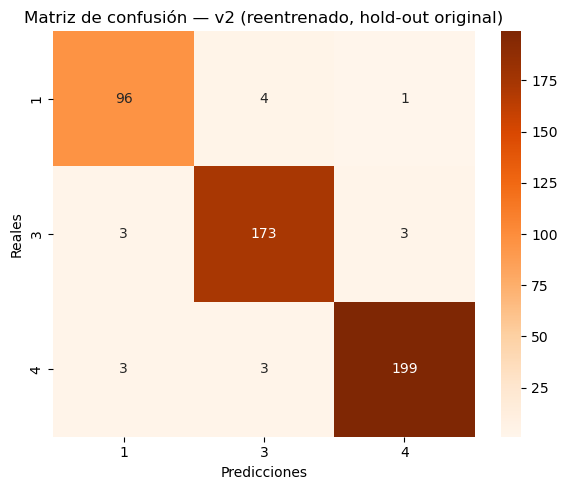

Guardadas matriz de confusión: artifacts/matriz_confusion_v2_holdout.(csv|png)
Guardados v2: artifacts/model_LogisticRegression_v2.joblib, artifacts/tfidf_vectorizer_v2.joblib


In [12]:
# ========== 6) REENTRENAMIENTO (v2) ==========
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

# --- 0) Asegurar carpeta de artefactos
os.makedirs("artifacts", exist_ok=True)

# --- 1) Usar sintéticos MULTI-CLASE si existen; si no, caer a df_sint (solo ODS1)
if 'df_sint_all' in globals() and isinstance(df_sint_all, pd.DataFrame) and len(df_sint_all) > 0:
    df_sint_used = df_sint_all[["texto_lema","labels"]].copy()
    print(f"Usando df_sint_all (multi-clase): {len(df_sint_used)} filas")
elif 'df_sint' in globals() and isinstance(df_sint, pd.DataFrame) and len(df_sint) > 0:
    df_sint_used = df_sint[["texto_lema","labels"]].copy()
    print(f"Usando df_sint (solo ODS1): {len(df_sint_used)} filas")
else:
    # si no hay sintéticos, entrenar igual (no recomendado, pero evita romper el flujo)
    df_sint_used = pd.DataFrame(columns=["texto_lema","labels"])
    print("No hay sintéticos disponibles. Se reentrena solo con original+nuevo.")

# --- 2) Armar el set de entrenamiento v2 (train original + nuevo set + sintéticos)
df_train_v2 = pd.DataFrame({"texto_lema": X_train.values, "labels": y_train.values})
df_train_v2 = pd.concat([df_train_v2, df_new[["texto_lema","labels"]], df_sint_used], ignore_index=True)
print(f"Tamaño train v2: {len(df_train_v2)}")

# --- 3) Vectorizador y modelo v2 (misma configuración que v1 para comparabilidad)
vectorizer_v2 = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9, sublinear_tf=True, norm="l2")
Xtr2 = vectorizer_v2.fit_transform(df_train_v2["texto_lema"])
ytr2 = df_train_v2["labels"].values

logreg_v2 = LogisticRegression(max_iter=2000, solver="lbfgs")
logreg_v2.fit(Xtr2, ytr2)

# --- 4) Evaluar v2 en el MISMO test original (comparación justa)
X_test_v2 = vectorizer_v2.transform(X_test)
yhat_v2_hold = logreg_v2.predict(X_test_v2)

print("=== v2 en MISMO HOLD-OUT (Etapa 1) ===")
acc_v2 = accuracy_score(y_test, yhat_v2_hold)
f1m_v2 = f1_score(y_test, yhat_v2_hold, average="macro")
print("Accuracy:", round(acc_v2, 3))
print("F1-macro:", round(f1m_v2, 3))

# --- 5) Reporte detallado (con guardado a CSV)
rep_v2 = classification_report(y_test, yhat_v2_hold, output_dict=True, zero_division=0)
pd.DataFrame(rep_v2).to_csv("artifacts/reporte_v2_holdout.csv")
print("\n=== Reporte de clasificación — v2 (reentrenado en hold-out original) ===")
print(classification_report(y_test, yhat_v2_hold, zero_division=0))
print("Guardado reporte CSV: artifacts/reporte_v2_holdout.csv")

# --- 6) Matriz de confusión (orden de clases consistente)
labels_order = sorted(pd.Series(y_test).unique(), key=lambda x: str(x))
cm_v2 = confusion_matrix(y_test, yhat_v2_hold, labels=labels_order)

# Guardar también la matriz en CSV
cm_df = pd.DataFrame(cm_v2, index=[f"real_{c}" for c in labels_order], columns=[f"pred_{c}" for c in labels_order])
cm_df.to_csv("artifacts/matriz_confusion_v2_holdout.csv", index=True)

plt.figure(figsize=(6,5))
sns.heatmap(cm_v2,
            annot=True,
            fmt="d",
            cmap="Oranges",
            xticklabels=labels_order,
            yticklabels=labels_order)
plt.xlabel("Predicciones")
plt.ylabel("Reales")
plt.title("Matriz de confusión — v2 (reentrenado, hold-out original)")
plt.tight_layout()
plt.savefig("artifacts/matriz_confusion_v2_holdout.png", dpi=150)
plt.show()
print("Guardadas matriz de confusión: artifacts/matriz_confusion_v2_holdout.(csv|png)")

# --- 7) Guardar artefactos del modelo v2
dump(logreg_v2, "artifacts/model_LogisticRegression_v2.joblib")
dump(vectorizer_v2, "artifacts/tfidf_vectorizer_v2.joblib")
print("Guardados v2: artifacts/model_LogisticRegression_v2.joblib, artifacts/tfidf_vectorizer_v2.joblib")


Tabla limpia guardada en: figures/tabla_comparativa_v1_vs_v2_mismo_test_CLEAN.csv


,Modelo,Accuracy,F1_macro,F1_ODS1,F1_ODS3,F1_ODS4
0,v1 (sin aumentación),0.9608,0.9559,0.9333,0.9584,0.9758
1,v2 (con aumentación),0.9649,0.9617,0.9458,0.9638,0.9755
2,Δ (v2 − v1),0.0041,0.0058,0.0125,0.0053,-0.0004


Gráfico guardado: figures/f1_por_clase_mismo_test.png
Gráfico guardado: figures/accuracy_f1macro_v1_vs_v2.png


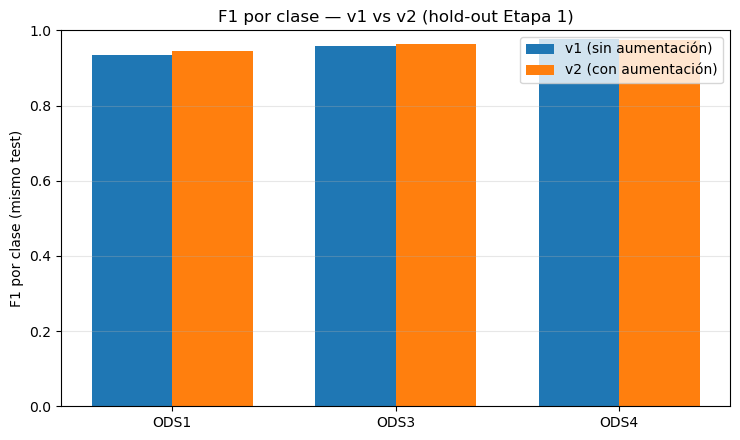

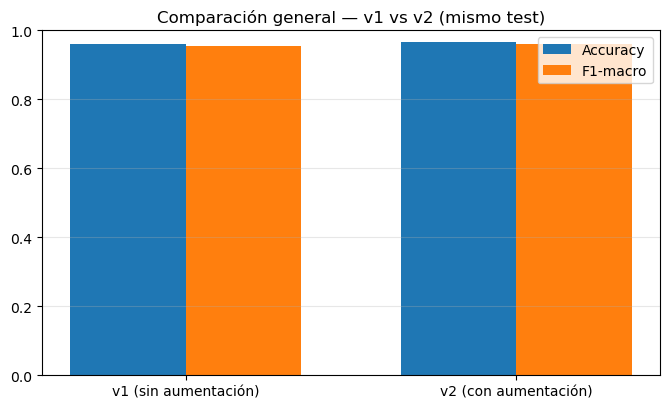

In [13]:
# ========== 7) COMPARACIÓN v1 vs v2 EN MISMO TEST  ==========
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, f1_score

os.makedirs("figures", exist_ok=True)

def fila_resumen(y_true, y_pred, nombre):
    rep = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    out = {
        "Modelo": nombre,
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1_macro": f1_score(y_true, y_pred, average="macro")
    }
    # F1 por clase (usa las etiquetas presentes en y_true)
    for cls in sorted(pd.Series(y_true).unique(), key=lambda x: str(x)):
        key = str(cls)
        if key in rep:
            out[f"F1_{key}"] = rep[key]["f1-score"]
    return out, rep

# Seguridad: verificar que existen las predicciones
assert 'yhat_v1_hold' in globals(), "Falta yhat_v1_hold (predicciones v1 en hold-out)."
assert 'yhat_v2_hold' in globals(), "Falta yhat_v2_hold (predicciones v2 en hold-out)."

fila_v1, rep_v1 = fila_resumen(y_test, yhat_v1_hold, "v1 (sin aumentación)")
fila_v2, rep_v2 = fila_resumen(y_test, yhat_v2_hold, "v2 (con aumentación)")

tabla_comp = pd.DataFrame([fila_v1, fila_v2])

# --- Orden columnas: Modelo, Accuracy, F1_macro, F1_ODS1/F1_ODS3/F1_ODS4 si existen ---
labels_test = sorted(pd.Series(y_test).unique(), key=lambda x: str(x))
def pretty_label(c):
    return f"ODS{c}" if isinstance(c, (int, np.integer)) else str(c)

cols = ["Modelo", "Accuracy", "F1_macro"] + [f"F1_{str(c)}" for c in labels_test]
tabla_comp = tabla_comp.reindex(columns=[c for c in cols if c in tabla_comp.columns])

# --- Renombrar F1_1 -> F1_ODS1, etc. para reporte más limpio ---
rename_map = {f"F1_{str(c)}": f"F1_{pretty_label(c)}" for c in labels_test}
tabla_comp = tabla_comp.rename(columns=rename_map)

# ---------- Opción A: TABLA LIMPIA sin NaN en filas de modelos y con fila Δ ----------
metrics = ["Accuracy", "F1_macro"] + [f"F1_{pretty_label(c)}" for c in labels_test]
metrics = [m for m in metrics if m in tabla_comp.columns]

# 1) Solo filas de modelos (v1, v2)
tabla_models = tabla_comp.loc[0:1, ["Modelo"] + metrics].copy()

# 2) Fila Δ (v2 − v1)
delta_vals = {"Modelo": "Δ (v2 − v1)"}
for m in metrics:
    delta_vals[m] = tabla_models.loc[1, m] - tabla_models.loc[0, m]

# 3) Unir y redondear
tabla_clean = pd.concat([tabla_models, pd.DataFrame([delta_vals])], ignore_index=True)
tabla_clean[metrics] = tabla_clean[metrics].round(4)

# 4) Guardar tabla limpia
tabla_clean.to_csv("figures/tabla_comparativa_v1_vs_v2_mismo_test_CLEAN.csv", index=False)
print("Tabla limpia guardada en: figures/tabla_comparativa_v1_vs_v2_mismo_test_CLEAN.csv")
display(tabla_clean)

# ---------- (Opcional) Gráfico F1 por clase ----------
try:
    f1_v1_cls = [rep_v1.get(str(c), {}).get("f1-score", np.nan) for c in labels_test]
    f1_v2_cls = [rep_v2.get(str(c), {}).get("f1-score", np.nan) for c in labels_test]
    xticks_labels = [pretty_label(c) for c in labels_test]

    x = np.arange(len(labels_test))
    plt.figure(figsize=(7.5, 4.5))
    plt.bar(x-0.18, f1_v1_cls, width=0.36, label="v1 (sin aumentación)")
    plt.bar(x+0.18, f1_v2_cls, width=0.36, label="v2 (con aumentación)")
    plt.xticks(x, xticks_labels)
    plt.ylim(0, 1.0)
    plt.ylabel("F1 por clase (mismo test)")
    plt.title("F1 por clase — v1 vs v2 (hold-out Etapa 1)")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.savefig("figures/f1_por_clase_mismo_test.png", dpi=150)
    print("Gráfico guardado: figures/f1_por_clase_mismo_test.png")
except Exception as e:
    print("No se pudo crear el gráfico F1 por clase:", e)

# ---------- (Opcional) Barras de Accuracy y F1_macro ----------
try:
    vals = tabla_models[["Modelo", "Accuracy", "F1_macro"]].copy()
    plt.figure(figsize=(6.8, 4.2))
    width = 0.35
    idx = np.arange(len(vals))
    plt.bar(idx - width/2, vals["Accuracy"], width=width, label="Accuracy")
    plt.bar(idx + width/2, vals["F1_macro"], width=width, label="F1-macro")
    plt.xticks(idx, vals["Modelo"], rotation=0)
    plt.ylim(0, 1.0)
    plt.title("Comparación general — v1 vs v2 (mismo test)")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.savefig("figures/accuracy_f1macro_v1_vs_v2.png", dpi=150)
    print("Gráfico guardado: figures/accuracy_f1macro_v1_vs_v2.png")
except Exception as e:
    print("No se pudo crear el gráfico de Accuracy/F1-macro:", e)


=== v2 EN NUEVO SET ===
Accuracy: 0.9899 | F1_macro: 0.9880
              precision    recall  f1-score   support

           1       1.00      0.95      0.98        21
           3       1.00      1.00      1.00        35
           4       0.98      1.00      0.99        43

    accuracy                           0.99        99
   macro avg       0.99      0.98      0.99        99
weighted avg       0.99      0.99      0.99        99

✔ Reportes guardados en: outputs/nuevo_set_v2_por_clase.csv y nuevo_set_v2_macro.csv

Predicciones v2 + score guardadas en: outputs/predicciones_v2_en_nuevo_set_con_score.csv
Clases del modelo v2: [1, 3, 4]


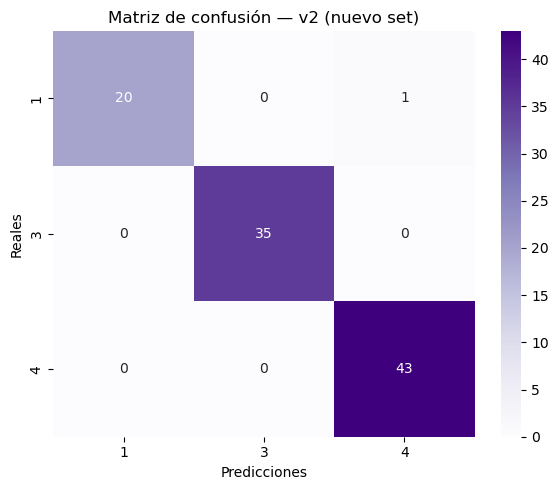

Matriz de confusión v2 guardada en: outputs/matriz_confusion_v2_nuevo_set.csv y figures/matriz_confusion_v2_nuevo_set.png

Comparación v1 vs v2 (nuevo set) guardada en: figures/tabla_v1_vs_v2_nuevo_set_CLEAN.csv


,Modelo,Accuracy,F1_macro,F1_1,F1_3,F1_4
0,v1 (sin aumentación),0.8990,0.8725,0.7647,0.9211,0.9318
1,v2 (con aumentación),0.9899,0.9880,0.9756,1.0000,0.9885
2,Δ (v2 − v1),0.0909,0.1155,0.2109,0.0789,0.0567


Gráfico guardado: figures/f1_por_clase_v1_vs_v2_nuevo_set.png


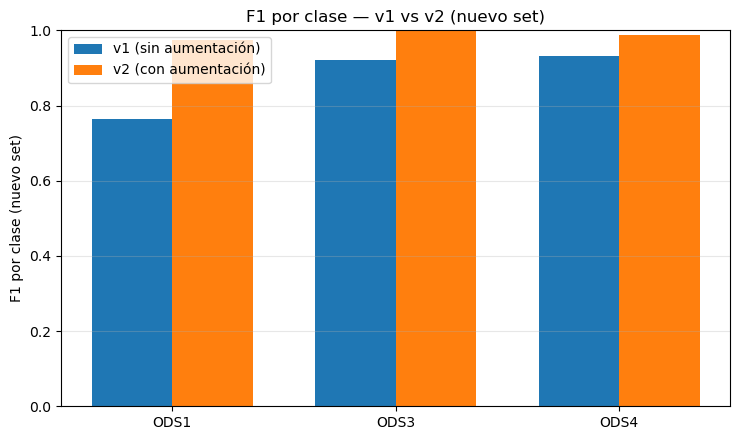

In [14]:
# ========== 8) v2 EN NUEVO SET (con comparación y probabilidad asociada) ==========
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score
)

os.makedirs("outputs", exist_ok=True)
os.makedirs("figures", exist_ok=True)

# --- Predicción con v2 en el nuevo set
X_new_v2 = vectorizer_v2.transform(df_new["texto_lema"])
y_new = df_new["labels"]
yhat_new_v2 = logreg_v2.predict(X_new_v2)

# --- Métricas por clase y macro
rep_new_v2 = classification_report(y_new, yhat_new_v2, output_dict=True, zero_division=0)
pd.DataFrame(rep_new_v2).to_csv("outputs/nuevo_set_v2_por_clase.csv")

acc_new_v2 = accuracy_score(y_new, yhat_new_v2)
f1m_new_v2 = f1_score(y_new, yhat_new_v2, average="macro")
pd.DataFrame([{"accuracy": acc_new_v2, "f1_macro": f1m_new_v2}]).to_csv("outputs/nuevo_set_v2_macro.csv", index=False)

print("=== v2 EN NUEVO SET ===")
print(f"Accuracy: {acc_new_v2:.4f} | F1_macro: {f1m_new_v2:.4f}")
print(classification_report(y_new, yhat_new_v2, zero_division=0))
print("✔ Reportes guardados en: outputs/nuevo_set_v2_por_clase.csv y nuevo_set_v2_macro.csv\n")

# ---guardar predicciones con score (probabilidad top-1)
def add_predictions_with_scores(df_texts, text_col, model, vectorizer, prefix="v2"):
    """
    Genera predicciones + probabilidad asociada (score) para cada texto.
    Devuelve un DataFrame con columnas:
      pred_<prefix>  : etiqueta predicha
      score_<prefix> : probabilidad asociada a esa predicción
    """
    Xmat = vectorizer.transform(df_texts[text_col].astype(str))
    yhat = model.predict(Xmat)
    proba = model.predict_proba(Xmat)
    classes = model.classes_

    col_index = {c: i for i, c in enumerate(classes)}
    idx = np.array([col_index[y] for y in yhat])
    score = proba[np.arange(len(yhat)), idx]

    out = df_texts.copy()
    out[f"pred_{prefix}"] = yhat
    out[f"score_{prefix}"] = score
    return out, classes

preds_v2_df, classes_v2 = add_predictions_with_scores(df_new, "texto_lema", logreg_v2, vectorizer_v2, prefix="v2")
preds_v2_df.to_csv("outputs/predicciones_v2_en_nuevo_set_con_score.csv", index=False)
print("Predicciones v2 + score guardadas en: outputs/predicciones_v2_en_nuevo_set_con_score.csv")
print("Clases del modelo v2:", list(classes_v2))

# --- Matriz de confusión (orden de clases consistente)
labels_order_new = sorted(pd.Series(y_new).unique(), key=lambda x: str(x))
cm_new_v2 = confusion_matrix(y_new, yhat_new_v2, labels=labels_order_new)

cm_df_new_v2 = pd.DataFrame(
    cm_new_v2,
    index=[f"real_{c}" for c in labels_order_new],
    columns=[f"pred_{c}" for c in labels_order_new]
)
cm_df_new_v2.to_csv("outputs/matriz_confusion_v2_nuevo_set.csv", index=True)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_new_v2,
    annot=True,
    fmt="d",
    cmap="Purples",
    xticklabels=labels_order_new,
    yticklabels=labels_order_new
)
plt.xlabel("Predicciones")
plt.ylabel("Reales")
plt.title("Matriz de confusión — v2 (nuevo set)")
plt.tight_layout()
plt.savefig("figures/matriz_confusion_v2_nuevo_set.png", dpi=150)
plt.show()
print("Matriz de confusión v2 guardada en: outputs/matriz_confusion_v2_nuevo_set.csv y figures/matriz_confusion_v2_nuevo_set.png")

# ---------- (Opcional) Comparación v1 vs v2 en el NUEVO set ----------
if 'yhat_new' in globals():
    def fila_resumen(y_true, y_pred, nombre):
        rep = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
        out = {
            "Modelo": nombre,
            "Accuracy": accuracy_score(y_true, y_pred),
            "F1_macro": f1_score(y_true, y_pred, average="macro")
        }
        for cls in labels_order_new:
            key = str(cls)
            if key in rep:
                out[f"F1_{key}"] = rep[key]["f1-score"]
        return out, rep

    fila_v1_new, rep_v1_new = fila_resumen(y_new, yhat_new, "v1 (sin aumentación)")
    fila_v2_new, rep_v2_new = fila_resumen(y_new, yhat_new_v2, "v2 (con aumentación)")
    tabla_v1v2_new = pd.DataFrame([fila_v1_new, fila_v2_new])

    # Δ (v2−v1)
    delta_vals = {"Modelo": "Δ (v2 − v1)"}
    for col in tabla_v1v2_new.columns:
        if col != "Modelo" and pd.api.types.is_numeric_dtype(tabla_v1v2_new[col]):
            delta_vals[col] = tabla_v1v2_new.loc[1, col] - tabla_v1v2_new.loc[0, col]
    tabla_v1v2_new = pd.concat([tabla_v1v2_new, pd.DataFrame([delta_vals])], ignore_index=True)

    tabla_v1v2_new.to_csv("figures/tabla_v1_vs_v2_nuevo_set_CLEAN.csv", index=False)
    print("\nComparación v1 vs v2 (nuevo set) guardada en: figures/tabla_v1_vs_v2_nuevo_set_CLEAN.csv")
    display(tabla_v1v2_new.round(4))

    # Gráfico F1 por clase
    try:
        f1_v1_cls = [rep_v1_new.get(str(c), {}).get("f1-score", np.nan) for c in labels_order_new]
        f1_v2_cls = [rep_v2_new.get(str(c), {}).get("f1-score", np.nan) for c in labels_order_new]
        xticks_labels = [f"ODS{c}" if isinstance(c, (int, np.integer)) else str(c) for c in labels_order_new]

        x = np.arange(len(labels_order_new))
        plt.figure(figsize=(7.5, 4.5))
        plt.bar(x-0.18, f1_v1_cls, width=0.36, label="v1 (sin aumentación)")
        plt.bar(x+0.18, f1_v2_cls, width=0.36, label="v2 (con aumentación)")
        plt.xticks(x, xticks_labels)
        plt.ylim(0, 1.0)
        plt.ylabel("F1 por clase (nuevo set)")
        plt.title("F1 por clase — v1 vs v2 (nuevo set)")
        plt.legend()
        plt.grid(axis="y", alpha=0.3)
        plt.tight_layout()
        plt.savefig("figures/f1_por_clase_v1_vs_v2_nuevo_set.png", dpi=150)
        print("Gráfico guardado: figures/f1_por_clase_v1_vs_v2_nuevo_set.png")
    except Exception as e:
        print("No se pudo crear el gráfico F1 por clase (nuevo set):", e)
else:
    print("No se encontró baseline v1 (yhat_new). Solo se reporta v2.")


### Construcción del pipeline

In [15]:
# ========== PIPELINE: TF-IDF + Logistic Regression con CV, fit final y guardado ==========
import os
import numpy as np
import pandas as pd
from joblib import dump
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, make_scorer

# --- Datos (asegúrate de tener df_train_v2, X_test, y_test definidos previamente)
X = df_train_v2["texto_lema"].astype(str)
y = df_train_v2["labels"]

os.makedirs("artifacts", exist_ok=True)
os.makedirs("figures", exist_ok=True)
os.makedirs("outputs", exist_ok=True)

def build_pipeline(class_weight="balanced", C=1.0):
    """Construye el pipeline con los mismos hiperparámetros que usas en v2."""
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(
            ngram_range=(1, 2),
            min_df=3,
            max_df=0.9,
            sublinear_tf=True,
            norm="l2"
        )),
        ("clf", LogisticRegression(
            max_iter=2000,
            solver="lbfgs",
            random_state=42,
            class_weight=class_weight,
            C=C
        ))
    ])
    return pipe

# --- CV estratificada (5 folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "accuracy": "accuracy",
    "f1_macro": "f1_macro",
    "f1_weighted": "f1_weighted"
}

pipe_cv = build_pipeline()
cv_res = cross_validate(pipe_cv, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_estimator=False)

print("=== Cross-Validation (5-fold) ===")
for k, v in cv_res.items():
    if k.startswith("test_"):
        metric = k.replace("test_", "")
        vals = v
        print(f"{metric:>12}: {vals.mean():.4f} ± {vals.std():.4f}  (folds: {np.round(vals, 4)})")

# --- Entrenar pipeline final en TODO el train_v2
pipe_final = build_pipeline()
pipe_final.fit(X, y)

# --- Evaluación en el MISMO hold-out usado en v1/v2 (comparación justa)
Xte_pipe = X_test.astype(str)  # por si X_test es Series
yhat_pipe = pipe_final.predict(Xte_pipe)

acc_pipe = accuracy_score(y_test, yhat_pipe)
f1m_pipe = f1_score(y_test, yhat_pipe, average="macro")
print("\n=== Pipeline (TF-IDF+LR) en hold-out ===")
print(f"Accuracy: {acc_pipe:.4f}")
print(f"F1_macro: {f1m_pipe:.4f}")
print("\nReporte por clase:\n", classification_report(y_test, yhat_pipe, zero_division=0))

# --- Guardar pipeline completo (vectorizador + modelo juntos)
dump(pipe_final, "artifacts/pipeline_tfidf_logreg_v2.joblib")
print("Guardado pipeline: artifacts/pipeline_tfidf_logreg_v2.joblib")

# (Opcional) Guardar también por separado vectorizador y clasificador desde el pipeline
try:
    tfidf_final = pipe_final.named_steps["tfidf"]
    clf_final   = pipe_final.named_steps["clf"]
    dump(tfidf_final, "artifacts/tfidf_vectorizer_v2_from_pipeline.joblib")
    dump(clf_final,   "artifacts/model_LogisticRegression_v2_from_pipeline.joblib")
    print("Guardados también por separado: tfidf_vectorizer_v2_from_pipeline.joblib, model_LogisticRegression_v2_from_pipeline.joblib")
except Exception as e:
    print("No se pudieron extraer/guardar pasos del pipeline:", e)

# --- (Opcional) Exportar predicciones en hold-out para auditoría
pd.DataFrame({
    "texto_lema": X_test.values,
    "y_true": y_test.values,
    "y_pred_pipeline": yhat_pipe
}).to_csv("outputs/predicciones_pipeline_holdout.csv", index=False)
print("Predicciones del pipeline en hold-out → outputs/predicciones_pipeline_holdout.csv")


=== Cross-Validation (5-fold) ===
    accuracy: 0.9768 ± 0.0059  (folds: [0.9752 0.9855 0.9731 0.9814 0.9689])
    f1_macro: 0.9766 ± 0.0060  (folds: [0.9749 0.9855 0.9728 0.9813 0.9687])
 f1_weighted: 0.9768 ± 0.0059  (folds: [0.9751 0.9855 0.9731 0.9813 0.9688])

=== Pipeline (TF-IDF+LR) en hold-out ===
Accuracy: 0.9649
F1_macro: 0.9617

Reporte por clase:
               precision    recall  f1-score   support

           1       0.94      0.95      0.95       101
           3       0.96      0.97      0.96       179
           4       0.98      0.97      0.98       205

    accuracy                           0.96       485
   macro avg       0.96      0.96      0.96       485
weighted avg       0.97      0.96      0.96       485

Guardado pipeline: artifacts/pipeline_tfidf_logreg_v2.joblib
Guardados también por separado: tfidf_vectorizer_v2_from_pipeline.joblib, model_LogisticRegression_v2_from_pipeline.joblib
Predicciones del pipeline en hold-out → outputs/predicciones_pipeline_hol

### Guardar el modelo

In [16]:
# ========== 9) GESTIÓN Y VERSIONADO DE MODELOS ==========
import joblib
from pathlib import Path
from datetime import datetime

# Carpeta donde se guardarán los modelos versionados
MODEL_DIR = Path("models")
MODEL_DIR.mkdir(exist_ok=True)

# Ruta al modelo "actual" (último en producción)
CURRENT_MODEL_PATH = MODEL_DIR / "model_current.joblib"

def save_model(model, replace_current=True, prefix="model"):
    
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    versioned_path = MODEL_DIR / f"{prefix}_{ts}.joblib"
    
    joblib.dump(model, versioned_path)
    print(f"Modelo guardado con versión: {versioned_path.name}")
    
    if replace_current:
        joblib.dump(model, CURRENT_MODEL_PATH)
        print(f"Modelo actualizado como 'actual': {CURRENT_MODEL_PATH.name}")
    
    return str(versioned_path)

def load_current_model():
    """
    Carga el modelo más reciente (model_current.joblib).
    Retorna el pipeline o modelo LogisticRegression.
    """
    if not CURRENT_MODEL_PATH.exists():
        raise FileNotFoundError("No existe un modelo actual. Guarda uno primero con save_model().")
    print(f"Cargando modelo actual desde: {CURRENT_MODEL_PATH}")
    return joblib.load(CURRENT_MODEL_PATH)
